In [1]:
import fio.database
import os

os.environ["GUROBI_HOME"] = "/Library/gurobi1203/macos_universal2"

import mip

db = fio.database.load_db("data/base.json")

print(db.keys())

dict_keys(['assemblers', 'items', 'miners', 'modules', 'recipes', 'resources', 'versions'])


In [2]:
import functools

@functools.lru_cache(64)
def get_assembly_machines(category, craftable_only=True):
  ms = []

  for m in db.assemblers.find(f""".[] | select(.crafting_categories | contains(["{category}"]))"""):
    ms.append(m)

  return ms

recipes = fio.database.HyperDiGraph()

ignore_machines = ["steel-furnace", "stone-furnace"]

for r in db.recipes.find(".[]"):
    for m in get_assembly_machines(r['category']):

        if m["name"] in ignore_machines:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})


In [3]:
import json
from collections import defaultdict

# Load a sample JSON file
with open('data/base.json', 'r') as json_file:
    data = json.load(json_file)



# Analyze the JSON data
def analyze_json(json_data, output=None, parent_key=[]):
    if output is None:
        output = defaultdict(set)
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            new_key = parent_key + [key]
            analyze_json(value, output, parent_key=new_key)
    elif isinstance(json_data, list):
        for item in json_data:
            analyze_json(item, output, parent_key=parent_key)
    else:
        output[tuple(parent_key)].add(type(json_data))
    
    return output

# Call the analyze_json function on the JSON data
analyze_json(data)

defaultdict(set,
            {('assemblers', 'allowed_effects', 'consumption'): {bool},
             ('assemblers', 'allowed_effects', 'pollution'): {bool},
             ('assemblers', 'allowed_effects', 'productivity'): {bool},
             ('assemblers', 'allowed_effects', 'speed'): {bool},
             ('assemblers', 'crafting_categories'): {str},
             ('assemblers', 'crafting_speed'): {float, int},
             ('assemblers', 'ingredient_count'): {int},
             ('assemblers', 'module_inventory_size'): {int},
             ('assemblers', 'name'): {str},
             ('items', 'name'): {str},
             ('items', 'stack_size'): {int},
             ('items', 'type'): {str},
             ('miners', 'allowed_effects', 'consumption'): {bool},
             ('miners', 'allowed_effects', 'pollution'): {bool},
             ('miners', 'allowed_effects', 'productivity'): {bool},
             ('miners', 'allowed_effects', 'speed'): {bool},
             ('miners', 'mining_speed'): 

In [4]:
import fio.flow


source = dict(**{resource: float("+inf") for resource in db.resources.query("map(.products[].name) | unique")})

source["water"] = float("+inf")

target = {
    k: 1 for k in {
        # 'basic-tech-card',
        # 'advanced-tech-card',
        # 'automation-science-pack',
        # 'biters-research-data',
        # 'chemical-science-pack',
        # 'logistic-science-pack',
        # 'production-science-pack',
        # 'utility-science-pack',
        # 'matter-research-data',
        # 'matter-tech-card',
        # 'military-science-pack',
        # 'singularity-tech-card',
        # "logistic-science-pack"
        # "advanced-logistic-science-pack",
        # "alien-science-pack",
        # "alien-science-pack-blue",
        # "alien-science-pack-green",
        # "alien-science-pack-orange",
        # "alien-science-pack-purple",
        # "alien-science-pack-red",
        # "alien-science-pack-yellow",
        "automation-science-pack",
        # "chemical-science-pack",
        # "logistic-science-pack",
        # "military-science-pack",
        # "production-science-pack",
        # "science-pack-gold",
        # "space-science-pack",
        # "steam-science-pack",
        # "utility-science-pack",

    }
}

print(source)

model = fio.flow.optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))

print(model["status"])
# model = build_detailed_graph(model)

{'coal': inf, 'copper-ore': inf, 'crude-oil': inf, 'iron-ore': inf, 'stone': inf, 'uranium-ore': inf, 'water': inf}
Set parameter Username
Set parameter LicenseID to value 2732003
Academic license - for non-commercial use only - expires 2026-11-03
Set parameter TimeLimit to value 30
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter FeasibilityTol to value 1e-06
Set parameter OptimalityTol to value 1e-06
Set parameter Method to value 3
Set parameter Seed to value 0
Set parameter PoolSolutions to value 10
Set parameter MIPGap to value 0.0001
Set parameter MIPGapAbs to value 1e-10
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
NodeLimit  1073741824
SolutionLimit  1073741824
TimeLimit  30
IntFeasTol  1e-06
Method  3

Optimize a model wi

In [5]:

from collections import defaultdict, namedtuple

inputs = defaultdict(float)
outputs = defaultdict(float)
c = defaultdict(int)


flows = []
i = 0


from uuid import uuid4

Cell = namedtuple("Cell", ["id", "recipe", "machine", "intergral", "fractional"])

class unique:
  def __init__(self, klass):
    self.c = defaultdict(int)
    self.klass = klass
  def __call__(self, i):
    r = self.c[i]
    self.c[i] += 1
    return f"{self.klass}_{i}_{r}"

unique_id = unique("transfo")

import networkx as nx
graph = nx.DiGraph()

per_rows = 4
for r, m, k, f in [tuple(k.split("#") + list(v)) for k, v in model["flow"].items()]:
    c[m] += k

    r = db.recipes.query(f"""map( select(.name == "{r}"))""")[0]

    m1 = db.assemblers.query(f"""map( select(.name == "{m}")) """)
    # m2 = db.furnace.query(f"""map( select(.name == "{m}")) """)
    m = (m1)[0]

    for _ in range(k-1):
      i = unique_id(r["name"])
      flows.append(Cell(i, r, m, 1, 1))
      graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=1)

    assert f-k+1 > 0
    i = unique_id(r["name"])
    flows.append(Cell(i, r, m, 1, f-k+1))
    graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=f-k+1)



In [6]:
nodes = list(graph.nodes(data=True))

new_graph = graph.copy()
for n, info in nodes:
  for i in info["recipe"]["ingredients"]:
    new_graph.add_edge(f'{i["type"]}_{i["name"]}', n, weight=i["amount"] * info["f"])
  
  for r in info["recipe"]["products"]:
    new_graph.add_edge(n, f'{r["type"]}_{r["name"]}', weight=i["amount"] * info["f"])

  
for n, info in new_graph.nodes(data=True):
  if "kind" not in info:
    info["kind"] = "product"


In [7]:
for node in new_graph.edges(data=True):
    print(node)

('transfo_automation-science-pack_0', 'item_automation-science-pack', {'weight': 1})
('transfo_automation-science-pack_1', 'item_automation-science-pack', {'weight': 1})
('transfo_automation-science-pack_2', 'item_automation-science-pack', {'weight': 1})
('transfo_automation-science-pack_3', 'item_automation-science-pack', {'weight': 1.0})
('transfo_copper-plate_0', 'item_copper-plate', {'weight': 1})
('transfo_copper-plate_1', 'item_copper-plate', {'weight': 0.6000000000000001})
('transfo_iron-gear-wheel_0', 'item_iron-gear-wheel', {'weight': 0.8})
('transfo_iron-plate_0', 'item_iron-plate', {'weight': 1})
('transfo_iron-plate_1', 'item_iron-plate', {'weight': 1})
('transfo_iron-plate_2', 'item_iron-plate', {'weight': 1})
('transfo_iron-plate_3', 'item_iron-plate', {'weight': 0.19999999999999973})
('item_copper-plate', 'transfo_automation-science-pack_0', {'weight': 1})
('item_copper-plate', 'transfo_automation-science-pack_1', {'weight': 1})
('item_copper-plate', 'transfo_automation-

# Blueprint construction

We don't need for each recipes to create a new blueprint: we only need one blueprint for each machines and fluids inputs and outputs.


In [8]:
import pandas as pd

df = {}

def select(data, kind1, kind2):
  return sum(1 for i in data["recipe"][kind1] if i["type"] == kind2)

for node, data in graph.nodes(data=True):
  if data["kind"] != "transformator":
    continue
  df[node] = {
    "machine": data["machine"]["name"],
    "recipe": data["recipe"]["name"],
    "item_in": select(data, "ingredients", "item"),
    "item_out": select(data, "products", "item"),
    "fluid_in": select(data, "ingredients", "fluid"),
    "fluid_out": select(data, "products", "fluid"),
    "data": data,
  }

df = pd.DataFrame(df).T

display(
  df.groupby(["machine", "item_in", "item_out", "fluid_in", "fluid_out"]).count()
)


recipe  data
machine              item_in item_out fluid_in fluid_out              
assembling-machine-3 1       1        0        0               1     1
                     2       1        0        0               4     4
electric-furnace     1       1        0        0               6     6

In [18]:
import fio.blueprint
from jsonpath import patch, match

def get_barrel_recipe(fluid_name, fill=True):
    """Get barrel recipe: fill=True -> 'fluid-barrel', fill=False -> 'empty-fluid-barrel'"""
    return f"{fluid_name}-barrel" if fill else f"empty-{fluid_name}-barrel"

def make_request_filters(ingredients, multiplier=5):
    """Create request filters from ingredients list"""
    return [{
        'index': k,
        'name': i["name"],
        'quality': 'normal',
        'comparator': '=',
        'count': i["amount"] * multiplier,
        'max_count': i["amount"] * multiplier * 2
    } for k, i in enumerate(ingredients, start=1) if i.get("type", "item") == "item"]

def make_overflow_condition(product, multiplier=20):
    """Create circuit condition to prevent chest overflow"""
    return {
        'first_signal': {'name': product["name"]},
        'constant': product["amount"] * multiplier,
        'comparator': '<'
    }


def choose_blueprint(data):
    if data["kind"] != "transformator":
        return None, 1, 1

    elif data["machine"]["name"] == "assembling-machine-3" and select(data, "ingredients", "fluid") > 0:
        bp = fio.blueprint.loads(open("blueprints/base/assembly-machine-fluid.b64").read())
        
        fluids_in = [i for i in data["recipe"]["ingredients"] if i.get("type") == "fluid"]
        fluids_out = [p for p in data["recipe"]["products"] if p.get("type") == "fluid"]
        items_in = [i for i in data["recipe"]["ingredients"] if i.get("type", "item") == "item"]
        items_out = [p for p in data["recipe"]["products"] if p.get("type", "item") == "item"]
        
        # Barrel filters: filled barrels for fluid inputs, empty barrels for fluid outputs
        barrel_filters = (
            [{'index': k, 'name': f"{f['name']}-barrel", 'quality': 'normal', 'comparator': '=', 
            'count': f["amount"]*5, 'max_count': f["amount"]*10} 
            for k, f in enumerate(fluids_in, 1)] +
            [{'index': k+len(fluids_in), 'name': 'barrel', 'quality': 'normal', 'comparator': '=',
            'count': f["amount"]*5, 'max_count': f["amount"]*10}
            for k, f in enumerate(fluids_out, 1)]
        )
        
        diff = {
            "/blueprint/entities/0/recipe": data["recipe"]["name"],
            "/blueprint/entities/6/request_filters/sections/0/filters": make_request_filters(items_in),
            "/blueprint/entities/8/request_filters/sections/0/filters": barrel_filters
        }
        
        if fluids_in:
            diff["/blueprint/entities/1/recipe"] = get_barrel_recipe(fluids_in[0]["name"], fill=False)
        if items_out:
            diff["/blueprint/entities/3/control_behavior/circuit_condition"] = make_overflow_condition(items_out[0])

    elif data["machine"]["name"] == "assembling-machine-3":
        bp = fio.blueprint.loads(open("blueprints/base/assembly-machine.b64").read())
        
        product = data["recipe"]["products"][0]
        diff = {
            "/blueprint/entities/0/recipe": data["recipe"]["name"],
            "/blueprint/entities/2/control_behavior/circuit_condition/first_signal/name": product["name"],
            "/blueprint/entities/2/control_behavior/circuit_condition/constant": product["amount"] * 20,
            "/blueprint/entities/3/request_filters/sections/0/filters": make_request_filters(data["recipe"]["ingredients"])
        }

    elif data["machine"]["name"] == "chemical-plant":
        bp = fio.blueprint.loads(open("blueprints/base/chemical-plant.b64").read())
        
        diff = {
            "/blueprint/entities/14/recipe": data["recipe"]["name"],
            "/blueprint/entities/13/request_filters/sections/0/filters": make_request_filters(data["recipe"]["ingredients"])
        }

    elif data["machine"]["name"] == "electric-furnace":
        bp = fio.blueprint.loads(open("blueprints/base/electric-furnace.b64").read())
        
        ingredient = data["recipe"]["ingredients"][0]
        product = data["recipe"]["products"][0]
        diff = {
            "/blueprint/entities/2/request_filters/sections/0/filters": make_request_filters([ingredient], multiplier=50),
            "/blueprint/entities/1/filters": [{'index': 1, 'name': product["name"], 'quality': 'normal', 'comparator': '='}]
        }

    elif data["machine"]["name"] == "oil-refinery":
        bp = fio.blueprint.loads(open("blueprints/base/oil-refinery.b64").read())
        
        fluids_in = [i for i in data["recipe"]["ingredients"] if i.get("type") == "fluid"]
        items_in = [i for i in data["recipe"]["ingredients"] if i.get("type", "item") == "item"]
        
        all_filters = (
            [{'index': k, 'name': f"{f['name']}-barrel", 'quality': 'normal', 'comparator': '=',
            'count': f["amount"]*5, 'max_count': f["amount"]*10}
            for k, f in enumerate(fluids_in, 1)] +
            make_request_filters(items_in)
        )
        
        diff = {
            "/blueprint/entities/19/recipe": data["recipe"]["name"],
            "/blueprint/entities/16/request_filters/sections/0/filters": all_filters,
            "/blueprint/entities/17/request_filters/sections/0/filters": all_filters
        }
    
    # modifies in-place
    patch.apply([{ "op": "replace", "path": k, "value": v } for k, v in diff.items()], bp)
    
    w = match("$.blueprint.snap-to-grid.x", bp)
    w = w.obj if w else 5
    h = match("$.blueprint.snap-to-grid.y", bp)
    h = h.obj if h else 5

    return bp, w, h

for node, data in new_graph.nodes(data=True):
    bp, w, h = choose_blueprint(data)
    new_graph.nodes[node]["w"] = w
    new_graph.nodes[node]["h"] = h
    new_graph.nodes[node]["bp"] = bp


In [17]:
print(fio.blueprint.loads(open("blueprints/base/assembly-machine-fluid.b64").read()))
print(fio.blueprint.loads(open("blueprints/base/assembly-machine.b64").read()))
print(fio.blueprint.loads(open("blueprints/base/chemical-plant.b64").read()))
print(fio.blueprint.loads(open("blueprints/base/electric-furnace.b64").read()))
print(fio.blueprint.loads(open("blueprints/base/oil-refinery.b64").read()))

{'blueprint': {'icons': [{'signal': {'name': 'assembling-machine-3'}, 'index': 1}], 'entities': [{'entity_number': 1, 'name': 'assembling-machine-3', 'position': {'x': 39.5, 'y': -12.5}, 'direction': 4, 'control_behavior': {'read_ingredients': True}, 'recipe': 'rocket-fuel', 'recipe_quality': 'normal'}, {'entity_number': 2, 'name': 'assembling-machine-3', 'position': {'x': 42.5, 'y': -12.5}, 'direction': 4, 'control_behavior': {'read_ingredients': True}, 'recipe': 'empty-lubricant-barrel', 'recipe_quality': 'normal'}, {'entity_number': 3, 'name': 'bulk-inserter', 'position': {'x': 39.5, 'y': -10.5}, 'direction': 8, 'control_behavior': {'circuit_set_filters': True}, 'filters': [{'index': 1, 'name': 'solid-fuel', 'quality': 'normal', 'comparator': '='}], 'use_filters': True}, {'entity_number': 4, 'name': 'bulk-inserter', 'position': {'x': 40.5, 'y': -10.5}}, {'entity_number': 5, 'name': 'bulk-inserter', 'position': {'x': 42.5, 'y': -10.5}, 'direction': 8, 'control_behavior': {'circuit_se

In [19]:

for node, data in new_graph.nodes(data=True):
    if data["machine"]["name"] == "assembling-machine-3":

        bp = fio.blueprint.loads(open("blueprints/base/assembly-machine.b64").read())
        
        request_filters = []

        for k, i in enumerate(data["recipe"]["ingredients"], start=1):
            request_filters.append(
                {
                    'index': k,
                    'name': i["name"],
                    'quality': 'normal',
                    'comparator': '=',
                    'count': i["amount"] * 5,
                    'max_count': i["amount"] * 10
                }
            )

        
        diff = {
            "/blueprint/entities/0/recipe": data["recipe"]["name"],
            "/blueprint/entities/2/control_behavior/circuit_condition/first_signal/name": data["recipe"]["products"][0]["name"],
            "/blueprint/entities/2/control_behavior/circuit_condition/constant": data["recipe"]["products"][0]["amount"] * 5,
            "/blueprint/entities/3/request_filters/sections/0/filters": request_filters  # This should work now
        }

        bp = patch.apply([{ "op": "replace", "path": k, "value": v } for k, v in diff.items()], bp)

        display(bp)
        print(fio.blueprint.dumps(bp))

        break

{'blueprint': {'snap-to-grid': {'x': 3, 'y': 5},
  'icons': [{'signal': {'name': 'assembling-machine-3'}, 'index': 1}],
  'entities': [{'entity_number': 1,
    'name': 'assembling-machine-3',
    'position': {'x': 1.5, 'y': 1.5},
    'control_behavior': {'read_ingredients': True},
    'recipe': 'automation-science-pack',
    'recipe_quality': 'normal'},
   {'entity_number': 2,
    'name': 'bulk-inserter',
    'position': {'x': 1.5, 'y': 3.5},
    'direction': 8},
   {'entity_number': 3,
    'name': 'bulk-inserter',
    'position': {'x': 2.5, 'y': 3.5},
    'control_behavior': {'circuit_enabled': True,
     'circuit_condition': {'first_signal': {'name': 'automation-science-pack'},
      'constant': 5,
      'comparator': '<'}}},
   {'entity_number': 4,
    'name': 'requester-chest',
    'position': {'x': 1.5, 'y': 4.5},
    'request_filters': {'sections': [{'index': 1,
       'filters': [{'index': 1,
         'name': 'copper-plate',
         'quality': 'normal',
         'comparator': '

0eJytVO1uozAQfJXKv89VCeFUTndPUkXImE2yqrFdf6StKt69a0MoSricTqqQwB/jnZ1h4IO1KoJ1qAP7dffBvBaWB8MPDru88Eb38scde6dnNdAApdGeJk8ExoMWKsO06IEGTHgPfatQH3gv5BE18JLlY7qDVKsYdjQDHTAgTHXy7L3RsW/BJQwhbhakfWs8VTB6brK4r6Y2aZQYqc/gjGpaOIoTGpeRDkTXUDEHHRJtaiC4CAnvQKIdOWMwvUjVuZcEk8CtkM9sBjUvUShqOYG1cT2ZQBWuhWwWQtqonjlqDy7Q3m0F5aigQ6KbII+rBOV/EWwuCVYtkuhkxNCAFq2CbnIooacNOtV9Fd6j86FZi8JfXJyIfRA5c1We9lY4EXIH7DcbhlW124VaBy8RPCnl8kjPfxi6HfVOh5o9Kjrpx8SPFk9RnGNK6C/Uxca5B2mspQasEgFSA9epuNL2Z1yKs/RevDXnefGQZZ+plulBRzYeQDj+egRQ38S2o2vV6WpBbekTxBO9PGdO2N00fHNp+M2AzTlaRG0vlIch/yNeKf3Z/CdKOdlOpYtd2sAAfQ78/OeixRO9qbGV6uem3tZ19ViUdf2wHYZPNA2QFQ==


In [11]:
new_graph.edges(data=True)

OutEdgeDataView([('transfo_automation-science-pack_0', 'item_automation-science-pack', {'weight': 1}), ('transfo_automation-science-pack_1', 'item_automation-science-pack', {'weight': 1}), ('transfo_automation-science-pack_2', 'item_automation-science-pack', {'weight': 1}), ('transfo_automation-science-pack_3', 'item_automation-science-pack', {'weight': 1.0}), ('transfo_copper-plate_0', 'item_copper-plate', {'weight': 1}), ('transfo_copper-plate_1', 'item_copper-plate', {'weight': 0.6000000000000001}), ('transfo_iron-gear-wheel_0', 'item_iron-gear-wheel', {'weight': 0.8}), ('transfo_iron-plate_0', 'item_iron-plate', {'weight': 1}), ('transfo_iron-plate_1', 'item_iron-plate', {'weight': 1}), ('transfo_iron-plate_2', 'item_iron-plate', {'weight': 1}), ('transfo_iron-plate_3', 'item_iron-plate', {'weight': 0.19999999999999973}), ('item_copper-plate', 'transfo_automation-science-pack_0', {'weight': 1}), ('item_copper-plate', 'transfo_automation-science-pack_1', {'weight': 1}), ('item_coppe

In [20]:

import gurobipy as gp
from gurobipy import GRB

class RectanglePacking:
    """
    Improved 2D rectangle packing with non-overlapping constraints.
    Addresses numerical issues and improves feasibility finding.
    """
    
    def __init__(self, nodes_data, edges_data):
        """
        Initialize the packing problem.
        
        Parameters:
        nodes_data: list of (node_id, {"w": width, "h": height}) tuples
        edges_data: list of (u, v, weight) tuples
        """
        self.nodes_data = nodes_data
        self.edges_data = edges_data
        self.env = None
        self.model = None
        self.x = {}
        self.y = {}
        self.b = {}
        self.d = {}
        
    def __enter__(self):
        return self
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.model:
            self.model.dispose()
        if self.env:
            self.env.dispose()
    
    def build_model(self, use_indicator=True, provide_start=True):
        """
        Build the optimization model.
        
        Parameters:
        use_indicator: If True, use indicator constraints (recommended)
        provide_start: If True, provide a simple initial solution
        """
        # Create environment and model
        self.env = gp.Env()
        self.model = gp.Model(env=self.env)
        
        # Create node dictionary
        self.nodes = {node_id: data for node_id, data in self.nodes_data}
        
        # Calculate tight bounds for the layout
        # Assume rectangles must fit in a canvas
        max_width = sum(data["w"] for _, data in self.nodes_data)
        max_height = sum(data["h"] for _, data in self.nodes_data)
        
        print(f"Problem size: {len(self.nodes)} nodes")
        print(f"Layout bounds: [{0}, {max_width}] x [{0}, {max_height}]")
        
        # Create position variables with tight bounds
        for node_id, data in self.nodes_data:
            self.x[node_id] = self.model.addVar(
                lb=0, 
                ub=max_width - data["w"],
                vtype=GRB.INTEGER,
                name=f"x_{node_id}"
            )
            self.y[node_id] = self.model.addVar(
                lb=0,
                ub=max_height - data["h"],
                vtype=GRB.INTEGER,
                name=f"y_{node_id}"
            )
        
        # Provide a simple MIP start: place rectangles in a grid
        if provide_start:
            self._provide_grid_start()
        
        # Add non-overlapping constraints for each pair of nodes
        node_ids = [node_id for node_id, _ in self.nodes_data]
        for i, n1 in enumerate(node_ids):
            d1 = self.nodes[n1]
            for n2 in node_ids[i+1:]:  # Only consider each pair once
                d2 = self.nodes[n2]
                
                # Create binary variables for relative positioning
                # b_left: n1 is completely to the left of n2
                # b_right: n1 is completely to the right of n2  
                # b_below: n1 is completely below n2
                # b_above: n1 is completely above n2
                self.b[(n1, n2, 'left')] = self.model.addVar(
                    vtype=GRB.BINARY, 
                    name=f"b_{n1}_{n2}_left"
                )
                self.b[(n1, n2, 'right')] = self.model.addVar(
                    vtype=GRB.BINARY,
                    name=f"b_{n1}_{n2}_right"
                )
                self.b[(n1, n2, 'below')] = self.model.addVar(
                    vtype=GRB.BINARY,
                    name=f"b_{n1}_{n2}_below"
                )
                self.b[(n1, n2, 'above')] = self.model.addVar(
                    vtype=GRB.BINARY,
                    name=f"b_{n1}_{n2}_above"
                )
                
                # At least one relative position must be true
                self.model.addConstr(
                    self.b[(n1, n2, 'left')] + 
                    self.b[(n1, n2, 'right')] + 
                    self.b[(n1, n2, 'below')] + 
                    self.b[(n1, n2, 'above')] >= 1,
                    name=f"overlap_{n1}_{n2}"
                )
                
                if use_indicator:
                    # Use indicator constraints (more efficient, no big-M needed)
                    # If b_left = 1, then x[n1] + width[n1] <= x[n2]
                    self.model.addGenConstrIndicator(
                        self.b[(n1, n2, 'left')], 1,
                        self.x[n1] + d1["w"] <= self.x[n2],
                        name=f"ind_left_{n1}_{n2}"
                    )
                    self.model.addGenConstrIndicator(
                        self.b[(n1, n2, 'right')], 1,
                        self.x[n2] + d2["w"] <= self.x[n1],
                        name=f"ind_right_{n1}_{n2}"
                    )
                    self.model.addGenConstrIndicator(
                        self.b[(n1, n2, 'below')], 1,
                        self.y[n1] + d1["h"] <= self.y[n2],
                        name=f"ind_below_{n1}_{n2}"
                    )
                    self.model.addGenConstrIndicator(
                        self.b[(n1, n2, 'above')], 1,
                        self.y[n2] + d2["h"] <= self.y[n1],
                        name=f"ind_above_{n1}_{n2}"
                    )
                else:
                    # Use big-M with tight bounds
                    M_x = max_width
                    M_y = max_height
                    
                    self.model.addConstr(
                        self.x[n1] + d1["w"] <= self.x[n2] + M_x * (1 - self.b[(n1, n2, 'left')]),
                        name=f"bigM_left_{n1}_{n2}"
                    )
                    self.model.addConstr(
                        self.x[n2] + d2["w"] <= self.x[n1] + M_x * (1 - self.b[(n1, n2, 'right')]),
                        name=f"bigM_right_{n1}_{n2}"
                    )
                    self.model.addConstr(
                        self.y[n1] + d1["h"] <= self.y[n2] + M_y * (1 - self.b[(n1, n2, 'below')]),
                        name=f"bigM_below_{n1}_{n2}"
                    )
                    self.model.addConstr(
                        self.y[n2] + d2["h"] <= self.y[n1] + M_y * (1 - self.b[(n1, n2, 'above')]),
                        name=f"bigM_above_{n1}_{n2}"
                    )
        
        # Add distance objective
        for u, v, w in self.edges_data:
            # Distance variable (Manhattan or Chebyshev distance)
            self.d[(u, v)] = self.model.addVar(
                vtype=GRB.CONTINUOUS,
                obj=w,
                name=f"d_{u}_{v}"
            )
            
            # Distance must be >= absolute differences
            self.model.addConstr(
                self.d[(u, v)] >= self.x[u] - self.x[v],
                name=f"dist_x1_{u}_{v}"
            )
            self.model.addConstr(
                self.d[(u, v)] >= self.x[v] - self.x[u],
                name=f"dist_x2_{u}_{v}"
            )
            self.model.addConstr(
                self.d[(u, v)] >= self.y[u] - self.y[v],
                name=f"dist_y1_{u}_{v}"
            )
            self.model.addConstr(
                self.d[(u, v)] >= self.y[v] - self.y[u],
                name=f"dist_y2_{u}_{v}"
            )
        
        self.model.update()
        print(f"Model built with {self.model.NumVars} variables and {self.model.NumConstrs} constraints")
    
    def _provide_grid_start(self):
        """
        Provide a simple grid-based initial solution as a MIP start.
        """
        import math
        
        node_ids = [node_id for node_id, _ in self.nodes_data]
        n = len(node_ids)
        grid_size = math.ceil(math.sqrt(n))
        
        # Calculate cell sizes
        max_w = max(data["w"] for _, data in self.nodes_data)
        max_h = max(data["h"] for _, data in self.nodes_data)
        
        for idx, node_id in enumerate(node_ids):
            row = idx // grid_size
            col = idx % grid_size
            
            # Set start values for position variables
            self.x[node_id].Start = col * (max_w + 1)
            self.y[node_id].Start = row * (max_h + 1)
        
        print("MIP start provided: simple grid layout")
    
    def optimize(self, time_limit=300):
        """
        Solve the model with parameters tuned for finding feasible solutions.
        """
        # Set parameters to focus on finding feasible solutions quickly
        self.model.Params.MIPFocus = 1  # Focus on feasibility
        self.model.Params.Heuristics = 0.15  # Increase heuristic effort
        self.model.Params.TimeLimit = time_limit
        self.model.Params.MIPGap = 0.05  # Accept 5% gap
        
        # For small problems, these can help
        if len(self.nodes) <= 20:
            self.model.Params.Cuts = 2  # Aggressive cuts
        
        print("\nOptimization parameters:")
        print(f"  MIPFocus = {self.model.Params.MIPFocus} (focus on feasibility)")
        print(f"  Heuristics = {self.model.Params.Heuristics}")
        print(f"  TimeLimit = {time_limit}s")
        print(f"  MIPGap = {self.model.Params.MIPGap}")
        print()
        
        self.model.optimize()
        
        return self.model.Status
    
    def print_solution(self):
        """
        Display the solution if one was found.
        """
        if self.model.SolCount > 0:
            print("\n" + "="*60)
            print("SOLUTION FOUND!")
            print("="*60)
            print(f"Objective value: {self.model.ObjVal:.2f}")
            print(f"MIP Gap: {self.model.MIPGap*100:.2f}%")
            print(f"Runtime: {self.model.Runtime:.2f}s")
            print(f"Nodes explored: {self.model.NodeCount}")
            print("\nRectangle positions:")
            for node_id in self.nodes:
                print(f"  {node_id}: ({self.x[node_id].X:.0f}, {self.y[node_id].X:.0f}) "
                      f"size=({self.nodes[node_id]['w']}x{self.nodes[node_id]['h']})")
        else:
            print("\n" + "="*60)
            print("NO SOLUTION FOUND")
            print("="*60)
            print(f"Status: {self.model.Status}")



nodes = list(new_graph.nodes(data=True))
edges = list(new_graph.edges(data="weight"))

print("Testing Rectangle Packing with Indicator Constraints")
print("="*60)

final_graph = new_graph.copy()

# Solve with indicator constraints (recommended)
with RectanglePacking(nodes, edges) as packer:
    packer.build_model(use_indicator=True, provide_start=True)
    status = packer.optimize(time_limit=10)
    for n in packer.nodes:
        final_graph.nodes[n]['x'] = packer.x[n].X
        final_graph.nodes[n]['y'] = packer.y[n].X


Testing Rectangle Packing with Indicator Constraints
Set parameter Username
Set parameter LicenseID to value 2732003
Academic license - for non-commercial use only - expires 2026-11-03
Problem size: 17 nodes
Layout bounds: [0, 51] x [0, 61]
MIP start provided: simple grid layout
Model built with 604 variables and 240 constraints
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.15
Set parameter TimeLimit to value 10
Set parameter MIPGap to value 0.05
Set parameter Cuts to value 2

Optimization parameters:
  MIPFocus = 1 (focus on feasibility)
  Heuristics = 0.15
  TimeLimit = 10s
  MIPGap = 0.05

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.05
Heuristics  0.15
MIPFocus  1
Cuts  2

Optimize a model with 240 rows, 604 columns and 856 nonzeros
Model fingerprint: 0x55649913
Model has 5

17

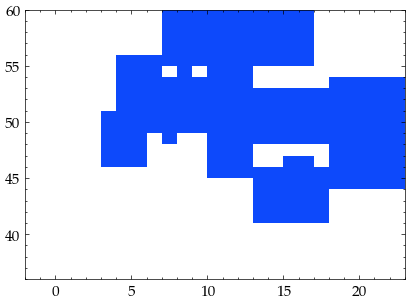

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from matplotlib import rc
rc('text', usetex=False) 

fig, ax = plt.subplots()

display(len(final_graph.nodes))
for node, data in final_graph.nodes(data=True):
    ax.add_patch(Rectangle((data["x"], data["y"]), data["w"], data["h"]))

x = nx.get_node_attributes(final_graph, "x").values()
w = nx.get_node_attributes(final_graph, "w").values()
y = nx.get_node_attributes(final_graph, "y").values()
h = nx.get_node_attributes(final_graph, "h").values()
plt.xlim(min(x)-max(w), max(x)+max(w))
plt.ylim(min(y)-max(h), max(y)+max(h))

plt.show()

# Blueprint Assembly

We now need to assemble the multiple blueprint widgets generated into one single blueprint. This requires to transpose each blueprints to its final positions, and combine the entity id with some offset.



In [23]:


import fio.blueprint

offset = 0



entities = []

for node, data in final_graph.nodes(data=True):
    if "bp" in data and data["bp"] is not None:
        data["x"]
        data["y"]
        offset += len(data["bp"]["blueprint"]["entities"])

        e = data["bp"]["blueprint"]["entities"]

        e = fio.blueprint.translate(data["x"], data["y"], e)
        # e = fio.blueprint.offset(offset, e)

        entities.extend(e)

print(fio.blueprint.dumps({"blueprint": {"icons": [],"entities": entities,"item": "blueprint","version": 281479275675648}}))



0eJztWuluozAQfpWK38sqAZOj2n2SVYUcmDRWuWpDtlWVd9/hSpyY5qB2mm1RI9UYey7m+zxM8mYtogIyzpLcur97s1iQJgJHfx5+3FmQ5CxnUF2/1VevflLEC+A4NcYVCY0BhxYVAuJFxJJHO6bBiiVguxbez1KBEtKkkv1Sbhr/9HD+FYceDjc4Ro05TyN/ASu6Zimv1nKgoY/iOIQMFZcm5LyAcj2HgGW11iJPY1rKt0WAywKwMxo8WdtF/nNBIzS6XJykPKaRhRJUVxzJlUURPdksEcBzvHfKB7f2IWSosFk061ThXqbCUVR0hilgPChY7kNCFxGETZTK1c0N3BXuRC8ZF7kv2GOCkSgnts/vnUg2ikVOq/xwRtV1nFFO88oE65e12XQ6TCSHOTwXINBZO1jh/5NRJbXLzTZ/ySLcK6qloo5zk5MsCeGlycXdqoMbrRVBmmVoQhbRHEoT1ORQvPtdTxWV96V5MX3x2+vxqHK8VSUnEeMYyUeg3P67Aog0aXvAv85Ye5LqDLHI1vj8eLpm4fGQO0rIj2bZNpmkfFvSSEC3Vb0IgmxNItP/lB8kF+Zm6MFTNHx1dtjF1BsN5HANcvCUiH86N8zOM+mWuUFywTHDDXNFw1fnhplSKw3cYJYb5pdVp9fgBu+8tL9lbvCUakw3N0wuq/e+ADdIMfUGbrgGN0yUiJviBojwsXEW2MuCJzSATnPc2X6trAGnksi2h7EH1FMuC5Czr6UfM5m2Kfs4hQBV4XEuOQdbrlrMHPU7TkPw06Wfohu0kTTuYhUlFYzBNuX9QDtScHQESOSy7JrvZ5dObLoHxaEeiBFXO8Qkkd8aYnIcBojpghgh5iAmyz4LYn1a52Ty0RK3o5a4UsuczIy3zFsVRovbwwh+Tqu87f9pxm7lXO+adnyIXcdo7/qsHqjpOpPsjtayLtJyCO5EktH1DsEez97oEShF4dg3hrd4BFahvMEDsGyfypmltW882n9e2uF